In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
total_df  = pd.read_csv('D:\\dataset\\product_demand\\HistoricalProductDemand.csv', parse_dates=['Date'])

Product_Code(2160) / Warehouse(4) / Product_Category(34) / Date / Order_Demand

In [3]:
total_df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016-04-27,1000
1048571,Product_1974,Whse_J,Category_006,2016-04-27,1
1048572,Product_1787,Whse_J,Category_006,2016-04-28,2500
1048573,Product_0901,Whse_J,Category_023,2016-10-07,50


Data Preprocessing

In [4]:
# Check any number of columns with NaN
print(total_df.isnull().any().sum(), ' / ', len(total_df.columns))
# Check any number of data points with NaN
print(total_df.isnull().any(axis=1).sum(), ' / ', len(total_df))

1  /  5
11239  /  1048575


In [5]:
#Lets check where these nulls are.
print (total_df.isna().sum())
print ('Null to Dataset Ratio in Dates: ',total_df.isnull().sum()[3]/total_df.shape[0]*100)
#There are missing values in Dates.

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
Null to Dataset Ratio in Dates:  1.0718355863910547


In [6]:
total_df.dropna(axis=0, inplace=True) #remove all rows with na's.
total_df.reset_index(drop=True)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
...,...,...,...,...,...
1037331,Product_1791,Whse_J,Category_006,2016-04-27,1000
1037332,Product_1974,Whse_J,Category_006,2016-04-27,1
1037333,Product_1787,Whse_J,Category_006,2016-04-28,2500
1037334,Product_0901,Whse_J,Category_023,2016-10-07,50


In [7]:
if total_df['Order_Demand'].dtype == 'int64':
    total_df['Order_Demand'] = total_df['Order_Demand'].abs()    

else :
    total_df['Order_Demand'] = total_df['Order_Demand'].str.replace('(',"")
    total_df['Order_Demand'] = total_df['Order_Demand'].str.replace(')',"")

    #Next step is to change the data type.
    total_df['Order_Demand'] = total_df['Order_Demand'].astype('int64')

In [8]:
total_df.head(20)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
5,Product_0979,Whse_J,Category_028,2012-04-19,500
6,Product_0979,Whse_J,Category_028,2012-06-05,500
7,Product_0979,Whse_J,Category_028,2012-06-27,500
8,Product_0979,Whse_J,Category_028,2012-07-23,500
9,Product_0979,Whse_J,Category_028,2012-08-29,500


In [9]:
#Get the lowest and highest dates in the dataset.
total_df['Date'].min() , total_df['Date'].max()
#There is data for 6 years. great.

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [10]:
cut_date_df = total_df[(total_df['Date']>='2012-01-01') & (total_df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

In [11]:
cut_date_df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
130870,Product_2166,Whse_S,Category_024,2012-01-01,2
196928,Product_0614,Whse_S,Category_001,2012-01-02,3
200087,Product_1281,Whse_S,Category_019,2012-01-02,14000
200086,Product_1355,Whse_S,Category_019,2012-01-02,5000
77313,Product_2169,Whse_S,Category_024,2012-01-02,55
...,...,...,...,...,...
995585,Product_0200,Whse_A,Category_007,2016-12-30,20
981262,Product_1388,Whse_A,Category_019,2016-12-30,100
999913,Product_1341,Whse_S,Category_019,2016-12-30,15000
981263,Product_1513,Whse_A,Category_019,2016-12-30,100


Exploring the Data as TIME SERIES

Considering only Order_Demand

In [12]:
order_df = cut_date_df.groupby('Date')['Order_Demand'].sum().reset_index()
order_df

,Date,Order_Demand
0,2012-01-01,2
1,2012-01-02,680277
2,2012-01-03,1645257
3,2012-01-04,1295861
4,2012-01-05,8941774
...,...,...
1676,2016-12-26,3628370
1677,2016-12-27,1674226
1678,2016-12-28,2740302
1679,2016-12-29,530487


- s: 초
- T: 분
- H: 시간
- D: 일(day)
- B: 주말이 아닌 평일
- W: 주(일요일)
- W-MON: 주(월요일)
- M: 각 달(month)의 마지막 날
- MS: 각 달의 첫날
- BM: 주말이 아닌 평일 중에서 각 달의 마지막 날
- BMS: 주말이 아닌 평일 중에서 각 달의 첫날
- WOM-2THU: 각 달의 두번째 목요일
- Q-JAN: 각 분기의 첫달의 마지막 날
- Q-DEC: 각 분기의 마지막 달의 마지막 날

In [13]:
order_df = order_df.set_index('Date')
y = order_df['Order_Demand'].resample('MS').mean()

In [14]:
y.head()

Date
2012-01-01    2.563139e+06
2012-02-01    3.105421e+06
2012-03-01    3.087972e+06
2012-04-01    2.668359e+06
2012-05-01    2.974002e+06
Freq: MS, Name: Order_Demand, dtype: float64

Reset df

In [15]:
cut_date_df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
130870,Product_2166,Whse_S,Category_024,2012-01-01,2
196928,Product_0614,Whse_S,Category_001,2012-01-02,3
200087,Product_1281,Whse_S,Category_019,2012-01-02,14000
200086,Product_1355,Whse_S,Category_019,2012-01-02,5000
77313,Product_2169,Whse_S,Category_024,2012-01-02,55
...,...,...,...,...,...
995585,Product_0200,Whse_A,Category_007,2016-12-30,20
981262,Product_1388,Whse_A,Category_019,2016-12-30,100
999913,Product_1341,Whse_S,Category_019,2016-12-30,15000
981263,Product_1513,Whse_A,Category_019,2016-12-30,100


#### Classified by category


Select the item with the highest contribution.

In [16]:
category_sum_df = pd.DataFrame(cut_date_df.groupby('Product_Category')['Order_Demand'].sum().sort_values(ascending=False))
category_sum_df["% Contribution"] = category_sum_df['Order_Demand']/category_sum_df['Order_Demand'].sum()*100
category_sum_df

,Order_Demand,% Contribution
Product_Category,,
Category_019,4233421162,82.595039
Category_006,405010821,7.901856
Category_005,198990170,3.882345
Category_007,128660495,2.510196
Category_028,48938528,0.954802
Category_033,42610000,0.831331
Category_030,40501055,0.790185
Category_021,4472098,0.087252
Category_032,4452008,0.086860


In [17]:
category_df = pd.pivot_table(cut_date_df,index=["Date"],values=["Order_Demand"],columns=["Product_Category"],aggfunc=np.sum)
category_df.columns = category_df.columns.droplevel(0)
category_df["Category_019"].dropna()

Date
2012-01-02     653950.0
2012-01-03    1499806.0
2012-01-04     626100.0
2012-01-05    7458199.0
2012-01-06    3452875.0
                ...    
2016-12-26    3101006.0
2016-12-27    1361794.0
2016-12-28    1830121.0
2016-12-29     388451.0
2016-12-30     621700.0
Name: Category_019, Length: 1579, dtype: float64

In [18]:
category_df

Product_Category,Category_001,Category_002,Category_003,Category_004,Category_005,Category_006,Category_007,Category_008,Category_009,Category_010,...,Category_024,Category_025,Category_026,Category_027,Category_028,Category_029,Category_030,Category_031,Category_032,Category_033
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-02,107.0,NaN,NaN,NaN,3500.0,13000.0,NaN,NaN,NaN,NaN,...,55.0,NaN,NaN,NaN,NaN,NaN,9000.0,NaN,540.0,NaN
2012-01-03,25.0,NaN,NaN,500.0,33600.0,72400.0,6952.0,NaN,1576.0,NaN,...,1058.0,NaN,114.0,NaN,8053.0,NaN,18600.0,10.0,36.0,NaN
2012-01-04,12.0,NaN,681.0,NaN,7200.0,563000.0,9334.0,NaN,14120.0,50.0,...,65.0,NaN,28.0,NaN,47205.0,NaN,21500.0,NaN,4110.0,NaN
2012-01-05,1071.0,NaN,27.0,NaN,147460.0,843602.0,421053.0,76.0,450.0,NaN,...,1184.0,NaN,30.0,NaN,32866.0,NaN,5900.0,NaN,942.0,20000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-26,4059.0,NaN,2.0,NaN,180750.0,257502.0,6887.0,NaN,222.0,NaN,...,456.0,NaN,42.0,NaN,4204.0,NaN,11000.0,NaN,50000.0,10000.0
2016-12-27,3774.0,NaN,4.0,NaN,121200.0,94703.0,17067.0,NaN,0.0,NaN,...,8.0,NaN,114.0,NaN,950.0,NaN,66900.0,NaN,6.0,NaN
2016-12-28,2869.0,NaN,NaN,NaN,441650.0,312506.0,74070.0,2.0,210.0,NaN,...,42.0,NaN,58.0,NaN,5827.0,NaN,65000.0,NaN,2006.0,NaN


Add all items by index of the beginning of the month.

In [19]:
y_category = category_df.resample('MS').sum() # Resampling the data on monthly basis 
y_category.index.freq = "MS" # Setting datetime frequency to Month
y_category.head(10)

Product_Category,Category_001,Category_002,Category_003,Category_004,Category_005,Category_006,Category_007,Category_008,Category_009,Category_010,...,Category_024,Category_025,Category_026,Category_027,Category_028,Category_029,Category_030,Category_031,Category_032,Category_033
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,22289.0,0.0,5848.0,900.0,2920345.0,6321967.0,2061395.0,268.0,46502.0,105.0,...,11827.0,0.0,3245.0,0.0,508190.0,32.0,407350.0,382.0,30010.0,600000.0
2012-02-01,26334.0,0.0,5750.0,3260.0,3213850.0,6558261.0,2425188.0,240.0,65603.0,97.0,...,18027.0,9000.0,6568.0,0.0,463039.0,820.0,657850.0,210.0,114560.0,900000.0
2012-03-01,30608.0,0.0,7659.0,2880.0,3251070.0,6211294.0,2493959.0,92.0,72578.0,88.0,...,23346.0,3000.0,5955.0,0.0,560369.0,753.0,553450.0,335.0,35466.0,530000.0
2012-04-01,21431.0,0.0,7244.0,1220.0,2626790.0,5847702.0,2788682.0,517.0,72066.0,161.0,...,22086.0,0.0,6878.0,0.0,374385.0,494.0,457450.0,118.0,61264.0,830000.0
2012-05-01,20422.0,0.0,8972.0,270.0,3480100.0,6428599.0,1709295.0,580.0,66965.0,1903.0,...,14790.0,0.0,7895.0,0.0,780988.0,725.0,436151.0,218.0,34796.0,980000.0
2012-06-01,21229.0,0.0,8384.0,4500.0,3269160.0,5629352.0,1901418.0,77.0,85013.0,95.0,...,21626.0,0.0,4294.0,0.0,1155006.0,1320.0,525050.0,253.0,120512.0,880000.0
2012-07-01,20592.0,0.0,5739.0,2140.0,2967605.0,4746436.0,1456442.0,208.0,60017.0,824.0,...,20156.0,0.0,5721.0,0.0,837761.0,310.0,470350.0,355.0,22080.0,710000.0
2012-08-01,18337.0,0.0,2779.0,3220.0,2739540.0,6010916.0,2338871.0,632.0,40183.0,444.0,...,13496.0,3000.0,4986.0,0.0,646016.0,822.0,833450.0,199.0,64918.0,700000.0
2012-09-01,19946.0,0.0,6962.0,1973.0,2606020.0,4136710.0,1379909.0,239.0,71521.0,151.0,...,12640.0,0.0,3822.0,0.0,797579.0,694.0,423350.0,508.0,18936.0,700000.0


In [20]:
df_019 = pd.DataFrame(y_category["Category_019"])
df_019.head()

,Category_019
Date,
2012-01-01,61243661.0
2012-02-01,72219508.0
2012-03-01,72444888.0
2012-04-01,61382420.0
2012-05-01,72041920.0


In [21]:
y_019 = df_019['Category_019'].resample('MS').mean()

Classified by Warehouse

In [22]:
wh_sum_df = pd.DataFrame(cut_date_df.groupby('Warehouse')['Order_Demand'].sum().sort_values(ascending=False))
wh_sum_df["% Contribution"] = wh_sum_df['Order_Demand']/wh_sum_df['Order_Demand'].sum()*100
wh_sum_df

,Order_Demand,% Contribution
Warehouse,,
Whse_J,3362742530,65.607895
Whse_S,1033121811,20.156449
Whse_C,582004179,11.355038
Whse_A,147646550,2.880619


In [23]:
wh_df = pd.pivot_table(cut_date_df,index=["Date"],values=["Order_Demand"],columns=["Warehouse"],aggfunc=np.sum)
wh_df.columns = wh_df.columns.droplevel(0)
wh_df["Whse_J"].dropna()

Date
2012-01-04        120.0
2012-01-05    4701940.0
2012-01-06    3832145.0
2012-01-09        200.0
2012-01-10    4316161.0
                ...    
2016-12-25          0.0
2016-12-26    3073044.0
2016-12-27    1215751.0
2016-12-28    2068312.0
2016-12-29     139046.0
Name: Whse_J, Length: 1394, dtype: float64

In [24]:
y_wh = wh_df.resample('MS').sum() # Resampling the data on monthly basis 
y_wh.index.freq = "MS" # Setting datetime frequency to Month
y_wh.head(10)

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
Date,,,,
2012-01-01,1920567.0,4255664.0,51534181.0,16620625.0
2012-02-01,2552035.0,10967000.0,57113723.0,16319022.0
2012-03-01,2362428.0,11296947.0,54925680.0,17878157.0
2012-04-01,1981391.0,7022400.0,49929642.0,15780620.0
2012-05-01,2723158.0,8203107.0,51342531.0,23977255.0
2012-06-01,2589293.0,8685737.0,53228352.0,19018297.0
2012-07-01,2638477.0,10815331.0,51778263.0,21839496.0
2012-08-01,2640359.0,9510199.0,47411474.0,15441209.0
2012-09-01,2232522.0,4733871.0,44120885.0,11661051.0


In [25]:
df_J = pd.DataFrame(y_wh["Whse_J"])
df_J.head()

,Whse_J
Date,
2012-01-01,51534181.0
2012-02-01,57113723.0
2012-03-01,54925680.0
2012-04-01,49929642.0
2012-05-01,51342531.0


In [26]:
y_J = df_J['Whse_J'].resample('MS').mean()

## ARIMA

Theory on ARIMA

An ARIMA model is characterized by 3 terms: p, d, q where these three parameters account for seasonality (p), trend (d), and noise in data (q):

 - p is the order of the AR term (number of lags of Y to be used as predictors). If it snowed for the last wee, it is likely it will snow tomorrow.
 - q is the order of the MA term (moving average).
 - d is the number of differencing required to make the time series stationary. if already stationary d=0.
 
But when dealing with SEASONALITY, it is best to incorporate it as 's'. ARIMA(p,d,q)(P,D,Q)s. Where 'pdq' are non seasonal params and 's' is the perdiocity of the time series. 4:quarter, 12:yearly etc.

In [27]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


#### considering only order_demand

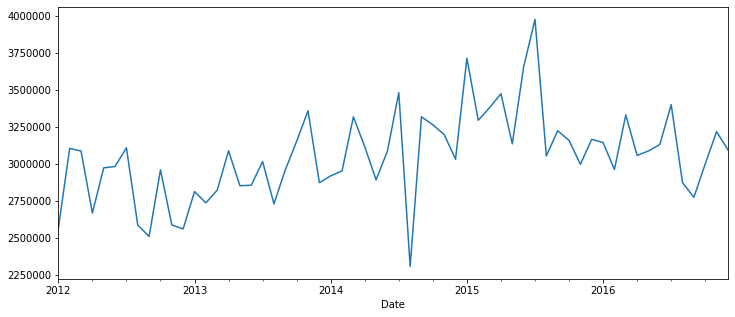

In [28]:
y.plot(figsize=(12,5))
plt.show()

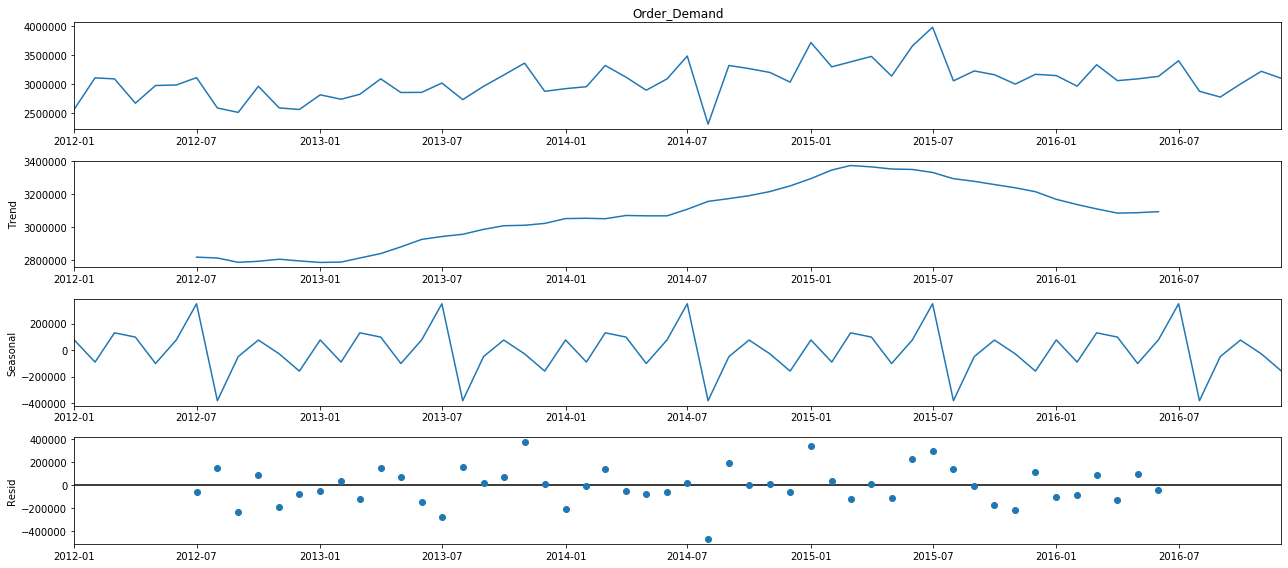

In [29]:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [30]:
#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            #y_019,
                                            #y_J,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1932.23655778549
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.927583212436
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1338.8201294951011
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2963.162309676349
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1366.5117513512635
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1340.8450308457734
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.6756022859483
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2987.9309958789995
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1862.0874878045222
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1471.1838032700646
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1305.3289813345482
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2883.609599551857
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1529.1005721650984
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.6395590277814
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1020.6347629759124
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2933.8366043265787
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1648.7378898187837
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AI

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                #y_019,
                                #y_J,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2450      0.368     -0.666      0.505      -0.966       0.476
ma.L1         -0.4385      0.325     -1.348      0.178      -1.076       0.199
ar.S.L12      -0.4568      0.208     -2.192      0.028      -0.865      -0.048
sigma2      1.018e+11   9.55e-13   1.06e+23      0.000    1.02e+11    1.02e+11


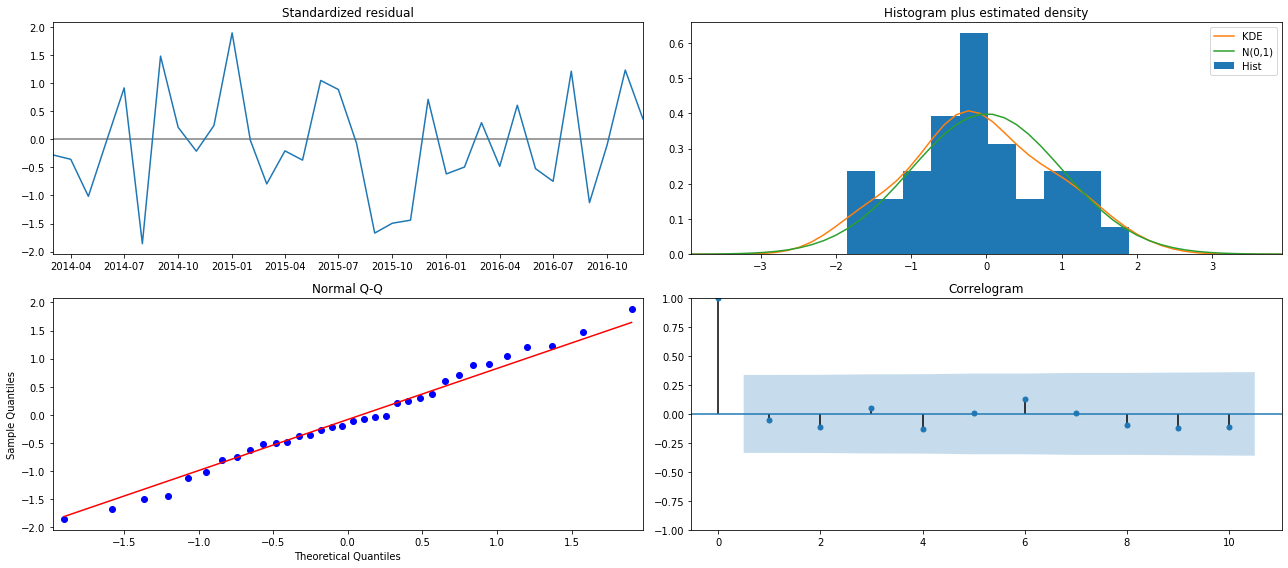

In [32]:
results.plot_diagnostics()
plt.tight_layout()
plt.show()

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.



Model Validation

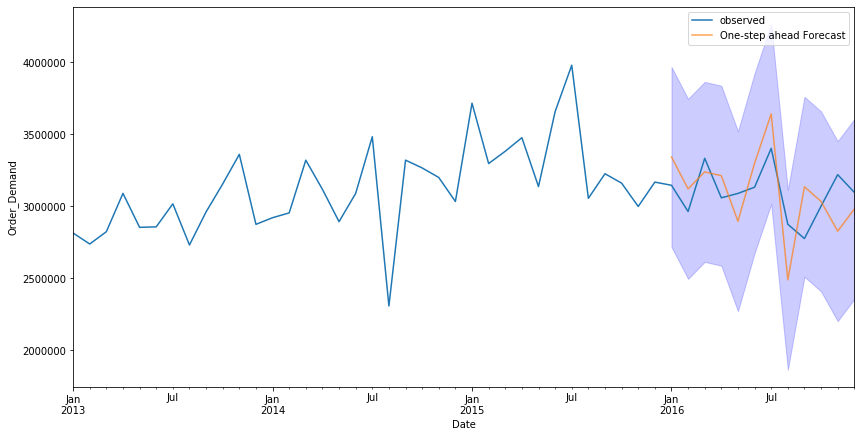

In [33]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False) #false is when using the entire history.
#pred = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)  ## when 

#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2013':].plot(label='observed')
# ax = y_019['2013':].plot(label='observed')
# ax = y_J['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

Forecast Accuracy

In [34]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-31':]
# y_truth = y_019['2016-01-31':]
# y_truth = y_J['2016-01-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

MSE 56983667898.78
RMSE: 238712.52


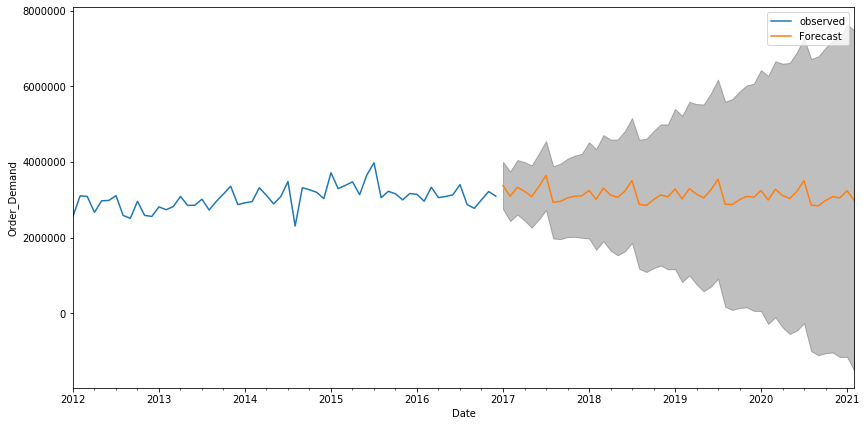

In [35]:
#The time can be changed using steps.
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
# ax = y_019.plot(label='observed', figsize=(14, 7))
# ax = y_J.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()